#  <center> Speech Emotion Recognition <center>

Name : Boobalamurugan S

Phase 1: Golden Task
    
Project Name : Speech Emotion Recognition

Date : 12/11/2023

## Introduction :

* Speech Emotion Recognition (SER) is a branch of affective computing focused on automatically identifying emotions expressed in spoken language. It involves extracting acoustic features from speech signals, utilizing machine learning models to correlate these features with emotional states, and often relies on labeled databases for training and evaluation. SER finds applications in human-computer interaction, customer service, mental health monitoring, and entertainment, enhancing systems by adapting to users' emotional states. Challenges include the subjectivity of emotions, context dependence, and variability in speech data.

## Problem statement :

* Speech Emotion Recognition (SER) is a branch of affective computing focused on automatically identifying emotions expressed in spoken language. It involves extracting acoustic features from speech signals, utilizing machine learning models to correlate these features with emotional states, and often relies on labeled databases for training and evaluation. SER finds applications in human-computer interaction, customer service, mental health monitoring, and entertainment, enhancing systems by adapting to users' emotional states. Challenges include the subjectivity of emotions, context dependence, and variability in speech data.

## solution statement :
* Developing an effective Speech Emotion Recognition system using machine learning to enhance applications in human-computer interaction, customer service, mental health monitoring, and entertainment by accurately identifying and responding to emotional states in spoken language

## About Dataset : 
* https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio/data

## <center>Lets start's

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Read Dataset and preprocessing

In [2]:
import os
import pandas as pd

# Specify the base directory
base_directory = "C:\\Users\\navee\\Downloads\\archive\\audio_speech_actors_01-24"

ravdess_directory_list = os.listdir(base_directory)

# Lists to store data
file_emotion = []
file_path = []

for directory in ravdess_directory_list:
    actor_files = os.listdir(os.path.join(base_directory, directory))
    
    for file in actor_files:
        parts = file.split('.')[0].split('-')
        
        # Third part in each file represents the emotion associated with that file.
        file_emotion.append(int(parts[2]))
        
        # Use os.path.join for better path concatenation
        file_path.append(os.path.join(base_directory, directory, file))

# Create a DataFrame with both emotion and path columns
Ravdess_df = pd.DataFrame({
    'Emotions': file_emotion,
    'Path': file_path
})

# Change integers to actual emotions
emotion_mapping = {1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'}
Ravdess_df['Emotions'] = Ravdess_df['Emotions'].replace(emotion_mapping)

# Display the first few rows
print(Ravdess_df.head())


  Emotions                                               Path
0  neutral  C:\Users\navee\Downloads\archive\audio_speech_...
1  neutral  C:\Users\navee\Downloads\archive\audio_speech_...
2  neutral  C:\Users\navee\Downloads\archive\audio_speech_...
3  neutral  C:\Users\navee\Downloads\archive\audio_speech_...
4     calm  C:\Users\navee\Downloads\archive\audio_speech_...


In [3]:
data_path =Ravdess_df
data_path.head()

,Emotions,Path
0,neutral,C:\Users\navee\Downloads\archive\audio_speech_...
1,neutral,C:\Users\navee\Downloads\archive\audio_speech_...
2,neutral,C:\Users\navee\Downloads\archive\audio_speech_...
3,neutral,C:\Users\navee\Downloads\archive\audio_speech_...
4,calm,C:\Users\navee\Downloads\archive\audio_speech_...


## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

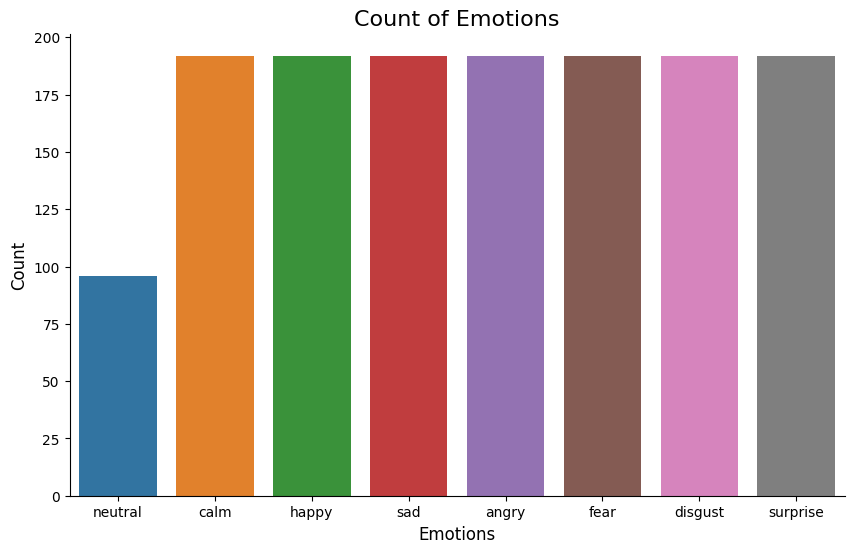

In [4]:
plt.figure(figsize=(10, 6))

plt.title('Count of Emotions', size=16)
sns.countplot(x='Emotions', data=Ravdess_df)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


In [5]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

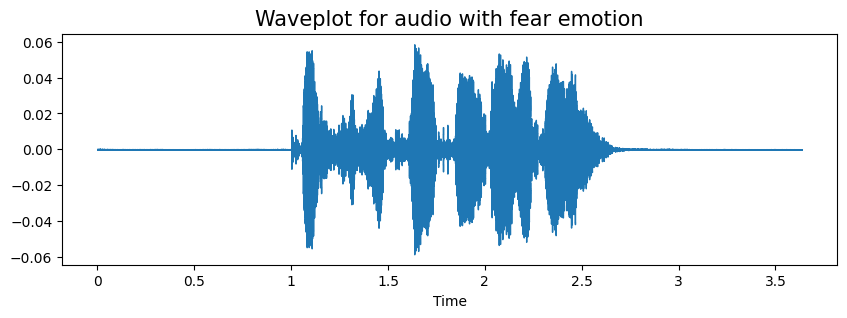

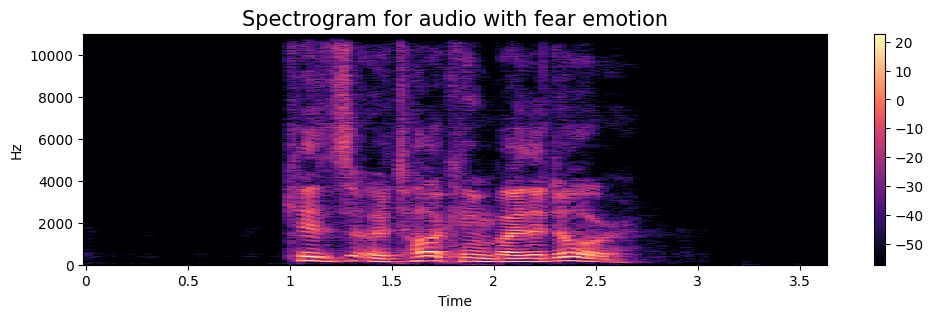

In [6]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

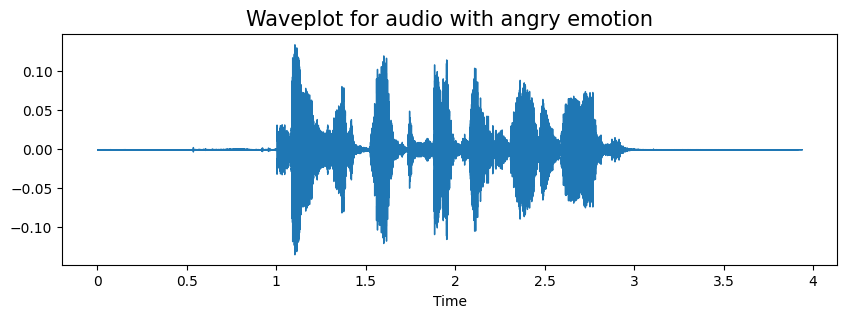

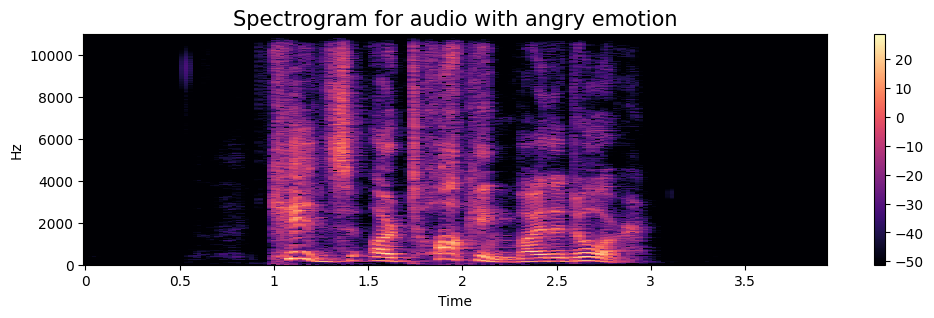

In [7]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

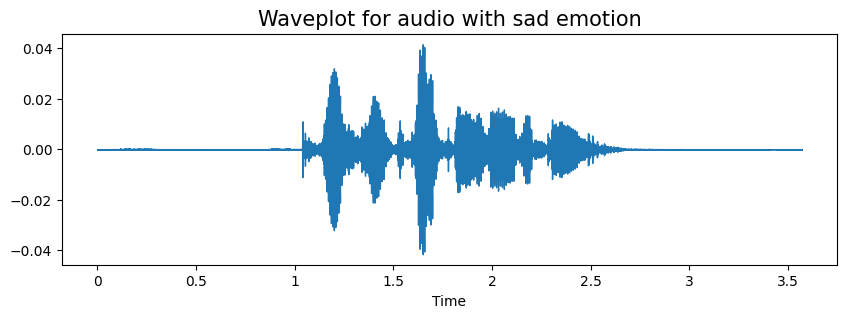

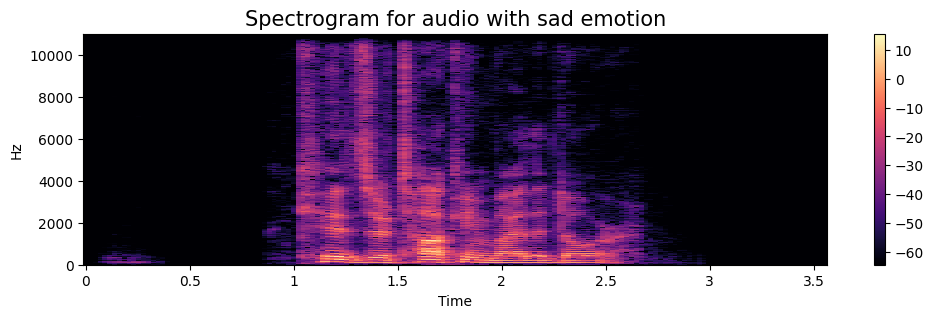

In [8]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

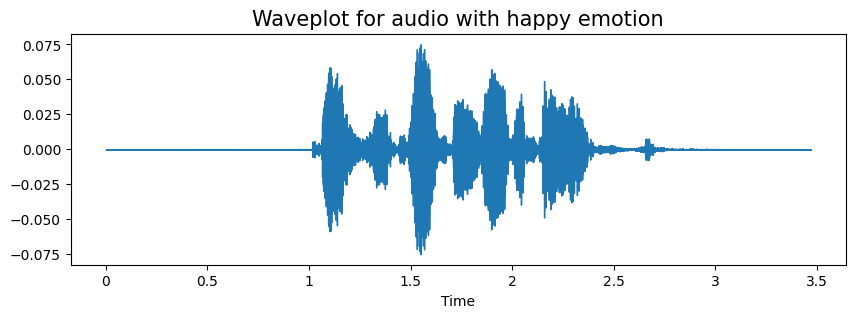

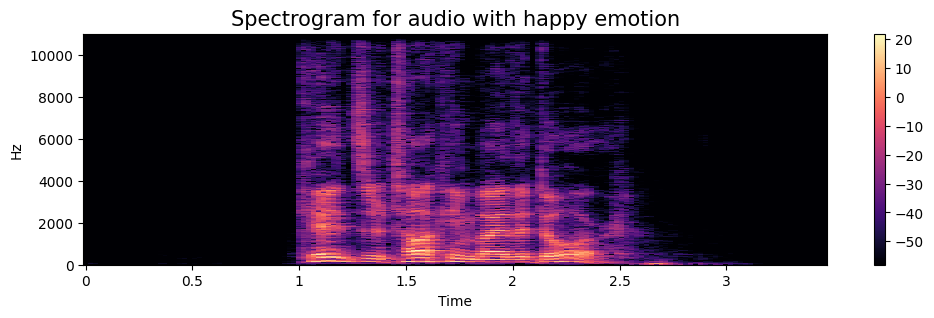

In [9]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation



In [10]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

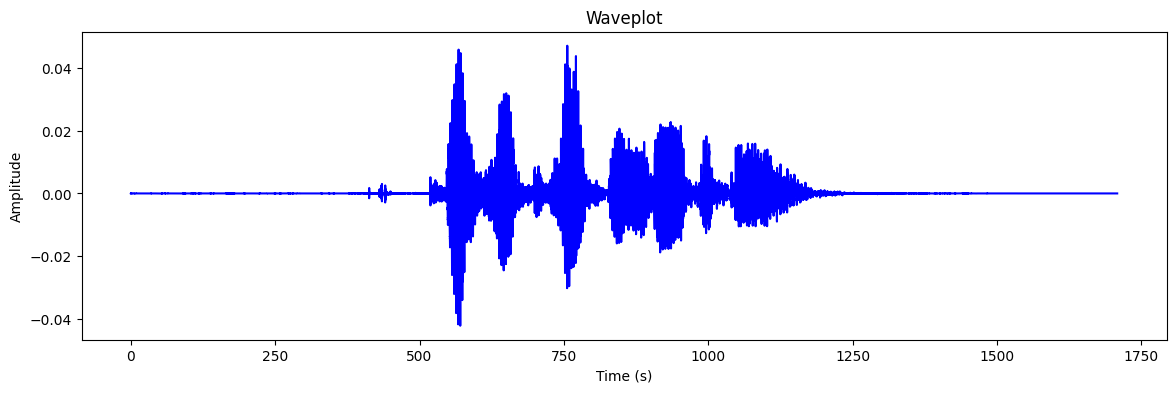

In [11]:
plt.figure(figsize=(14, 4))
plt.title('Waveplot')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.plot(librosa.times_like(data), data, label='Waveform', color='b')
plt.show()

# Play the audio
Audio(data, rate=sample_rate)

#### 2. Noise Injection

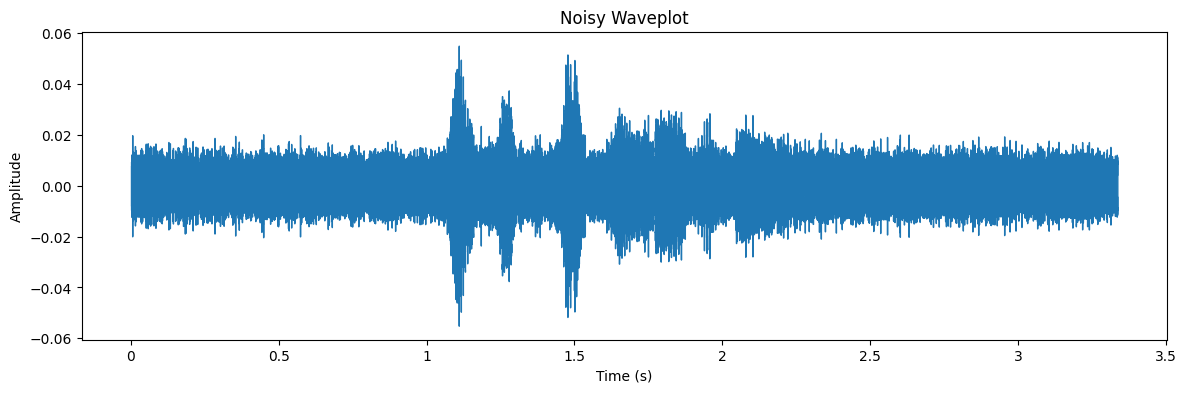

In [12]:
# Function to add noise to audio data
def add_noise(data, noise_level=0.005):
    noise = np.random.normal(0, noise_level, len(data))
    return data + noise

# Add noise to the audio data
noisy_data = add_noise(data)

# Display the waveplot of the noisy audio
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=noisy_data, sr=sample_rate)
plt.title('Noisy Waveplot')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Stretching

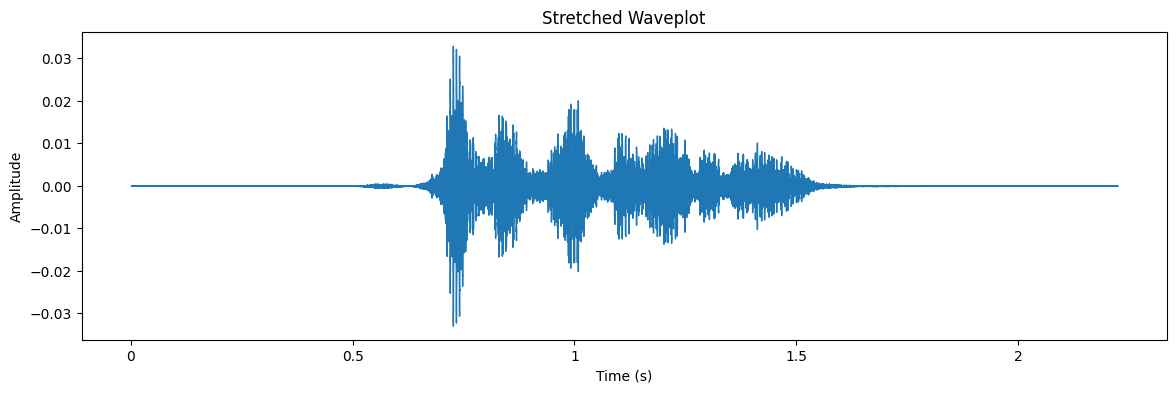

In [13]:
# Function to stretch the audio data
def stretch(data, rate=1.5):
    return librosa.effects.time_stretch(data, rate=rate)

# Stretch the audio data
stretched_data = stretch(data)

# Display the waveplot of the stretched audio
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=stretched_data, sr=sample_rate)
plt.title('Stretched Waveplot')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Play the stretched audio
Audio(stretched_data, rate=sample_rate)

#### 4. Shifting

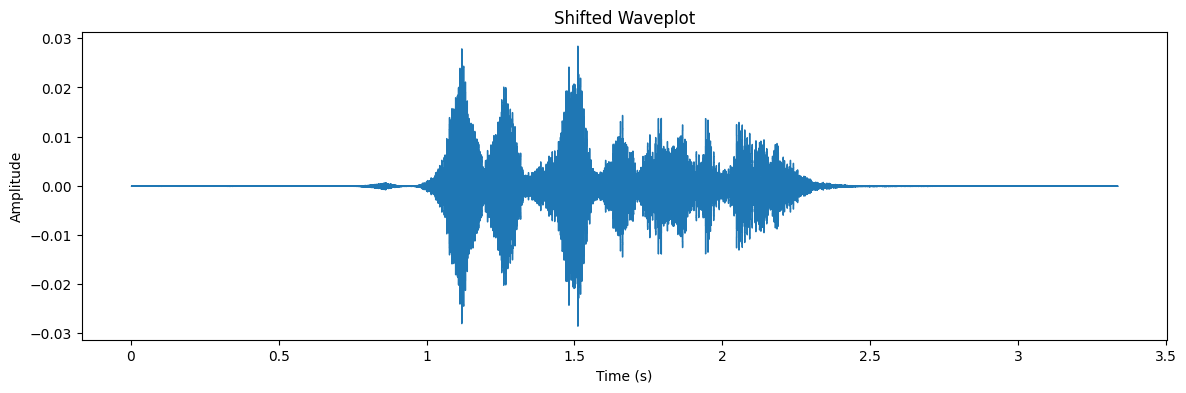

In [14]:
def shift(data, n_steps=2):
    return librosa.effects.pitch_shift(data, sr=sample_rate, n_steps=n_steps)

# Shift the audio data
shifted_data = shift(data)

# Display the waveplot of the shifted audio
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=shifted_data, sr=sample_rate)
plt.title('Shifted Waveplot')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Play the shifted audio
Audio(shifted_data, rate=sample_rate)

#### 5. Pitch

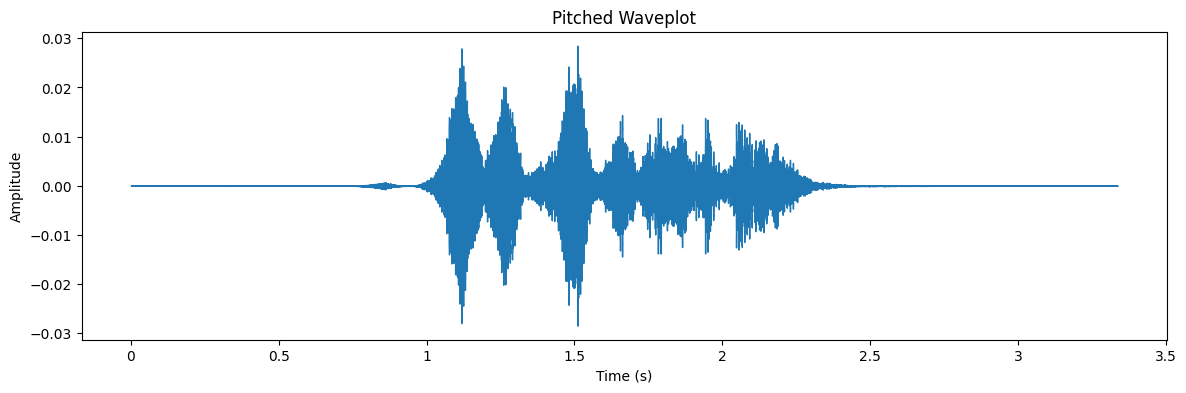

In [15]:
# Function to change the pitch of the audio data
def pitch(data, sample_rate, n_steps=2):
    return librosa.effects.pitch_shift(data, sr=sample_rate, n_steps=n_steps)

# Change the pitch of the audio data
pitched_data = pitch(data, sample_rate)

# Display the waveplot of the pitched audio
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=pitched_data, sr=sample_rate)
plt.title('Pitched Waveplot')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

## Feature Extraction


In [16]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [17]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [18]:
len(X), len(Y), data_path.Path.shape

(4320, 4320, (1440,))

In [19]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.321275,0.729664,0.750033,0.730624,0.735275,0.713529,0.660531,0.684966,0.733049,0.753972,...,4.310903e-06,3.291511e-06,2.148075e-06,2.279739e-06,5.116493e-06,8.190282e-06,7.024454e-06,5.051210e-06,4.245834e-07,neutral
1,0.275047,0.759565,0.774739,0.754015,0.766975,0.771702,0.683977,0.674143,0.726090,0.756107,...,5.104710e-06,3.976033e-06,2.871582e-06,3.038888e-06,5.976746e-06,8.836858e-06,7.863274e-06,5.793784e-06,1.239554e-06,neutral
2,0.183343,0.709902,0.640334,0.693064,0.748009,0.649328,0.582539,0.662070,0.673595,0.670786,...,8.706072e-07,4.654835e-07,5.598058e-07,6.984785e-07,5.810421e-07,5.342694e-07,5.420067e-07,1.631373e-07,1.685447e-08,neutral
3,0.293566,0.673896,0.722096,0.723508,0.682302,0.680533,0.675352,0.628977,0.679179,0.707283,...,6.984504e-06,7.034949e-06,6.654923e-06,6.979548e-06,1.214236e-05,9.640183e-06,1.096403e-05,5.543237e-06,4.254087e-07,neutral
4,0.308946,0.761838,0.795242,0.812606,0.777910,0.769323,0.737311,0.647473,0.680693,0.719697,...,5.598975e-05,5.433660e-05,5.420722e-05,5.490093e-05,5.882560e-05,5.747595e-05,5.785488e-05,5.257505e-05,4.810041e-05,neutral


## Data Preparation


In [20]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [21]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [22]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [23]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [24]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 8), (1080, 162, 1), (1080, 8))

## Modelling

In [25]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 128)          0

In [26]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=25, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/25
51/51 [==============================] - 9s 153ms/step - loss: 2.0193 - accuracy: 0.1633 - val_loss: 1.9698 - val_accuracy: 0.2463 - lr: 0.0010
Epoch 2/25
51/51 [==============================] - 7s 143ms/step - loss: 1.9712 - accuracy: 0.2111 - val_loss: 1.8972 - val_accuracy: 0.2491 - lr: 0.0010
Epoch 3/25
51/51 [==============================] - 7s 144ms/step - loss: 1.9391 - accuracy: 0.2219 - val_loss: 1.8170 - val_accuracy: 0.3139 - lr: 0.0010
Epoch 4/25
51/51 [==============================] - 7s 144ms/step - loss: 1.8867 - accuracy: 0.2608 - val_loss: 1.7774 - val_accuracy: 0.3102 - lr: 0.0010
Epoch 5/25
51/51 [==============================] - 6s 125ms/step - loss: 1.8284 - accuracy: 0.2830 - val_loss: 1.7138 - val_accuracy: 0.3639 - lr: 0.0010
Epoch 6/25
51/51 [==============================] - 6s 119ms/step - loss: 1.7719 - accuracy: 0.3148 - val_loss: 1.6538 - val_accuracy: 0.3954 - lr: 0.0010
Epoch 7/25
51/51 [==============================] - 6s 120ms/step - lo

34/34 [==============================] - 1s 20ms/step - loss: 1.3496 - accuracy: 0.5157
Accuracy of our model on test data :  51.57407522201538 %


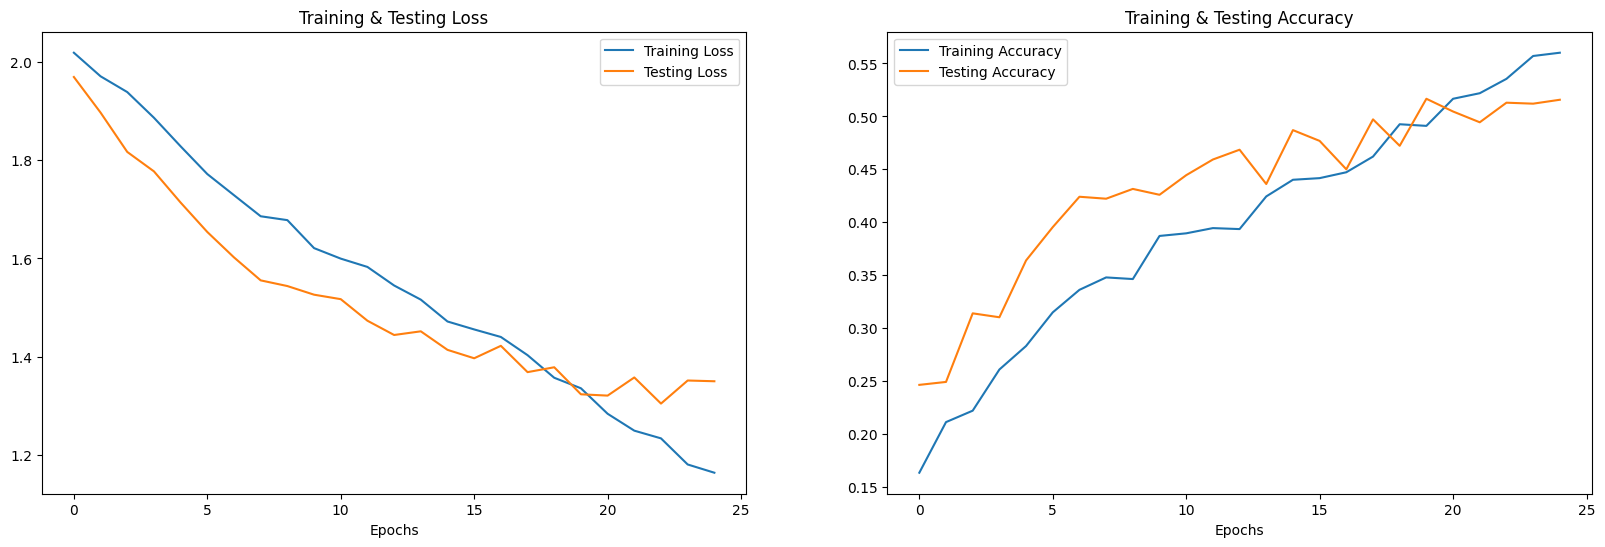

In [27]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(25)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [28]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

34/34 [==============================] - 1s 24ms/step


In [29]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,fear,fear
1,surprise,angry
2,fear,fear
3,neutral,calm
4,angry,angry
5,surprise,surprise
6,fear,fear
7,fear,happy
8,fear,fear
9,disgust,sad


## Confusion matrix

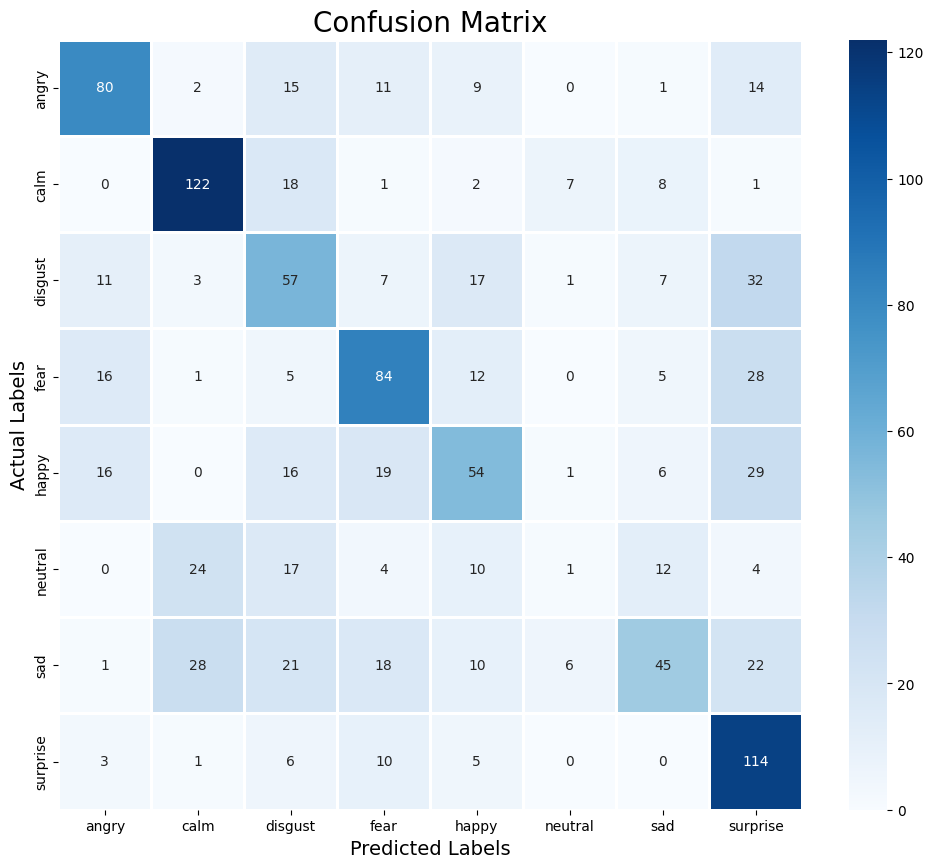

In [30]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.63      0.61      0.62       132
        calm       0.67      0.77      0.72       159
     disgust       0.37      0.42      0.39       135
        fear       0.55      0.56      0.55       151
       happy       0.45      0.38      0.42       141
     neutral       0.06      0.01      0.02        72
         sad       0.54      0.30      0.38       151
    surprise       0.47      0.82      0.60       139

    accuracy                           0.52      1080
   macro avg       0.47      0.48      0.46      1080
weighted avg       0.50      0.52      0.49      1080



## Conclusion :

* Speech Emotion Recognition through advanced machine learning techniques, addressing challenges for improved accuracy. The proposed system has the potential to significantly impact applications in human-computer interaction, customer service, mental health monitoring, and entertainment.





